<h2>프로젝트 추진배경</h2>

- 반도체 제조공정 배경
    - 최근 AI/빅데이터 분야에서 데이터 처리량이 급증하면서, 고대역폭메모리(HBM)에 대한 수요가 증가함.
    - 하지만, HBM은 높은 기술적 난이도로 인해 기존 D램보다 비싼 가격대를 형성함. ~ $180/chip
    - 수율 조건을 만족하면서, 불량칩이 연속적으로 생성되는 경우가 발생.

- 불량 원인
    - 진성불량 : 불량 판정을 받았으며, 실제로도 불량인 경우. ex) 적층된 웨이퍼 간 연결고리인 범프에 이물질이 혼입된 경우 발생.
    - 가성불량 : 불량 판정을 받았지만, 실제로는 정상인 경우. ex) 검사 장비에 이물질 부착으로 인한 측정 오류.

- 검사 장비에 이물질이 부착된 경우, 지속적으로 동일한 지점에서 불량이 발생함. 
- 이에 대해 조치를 취하지 않으면, 매 검사마다 1~2개의 불량칩이 발생하므로 비용적인 손실이 매우 큼.

<h3>따라서, 수율조건을 만족하면서 연속적으로 결함이 발생할 때, 실시간으로 문제 원인을 분석하는 모델을 개발하고자 함.</h3>

---
## Flow Chart

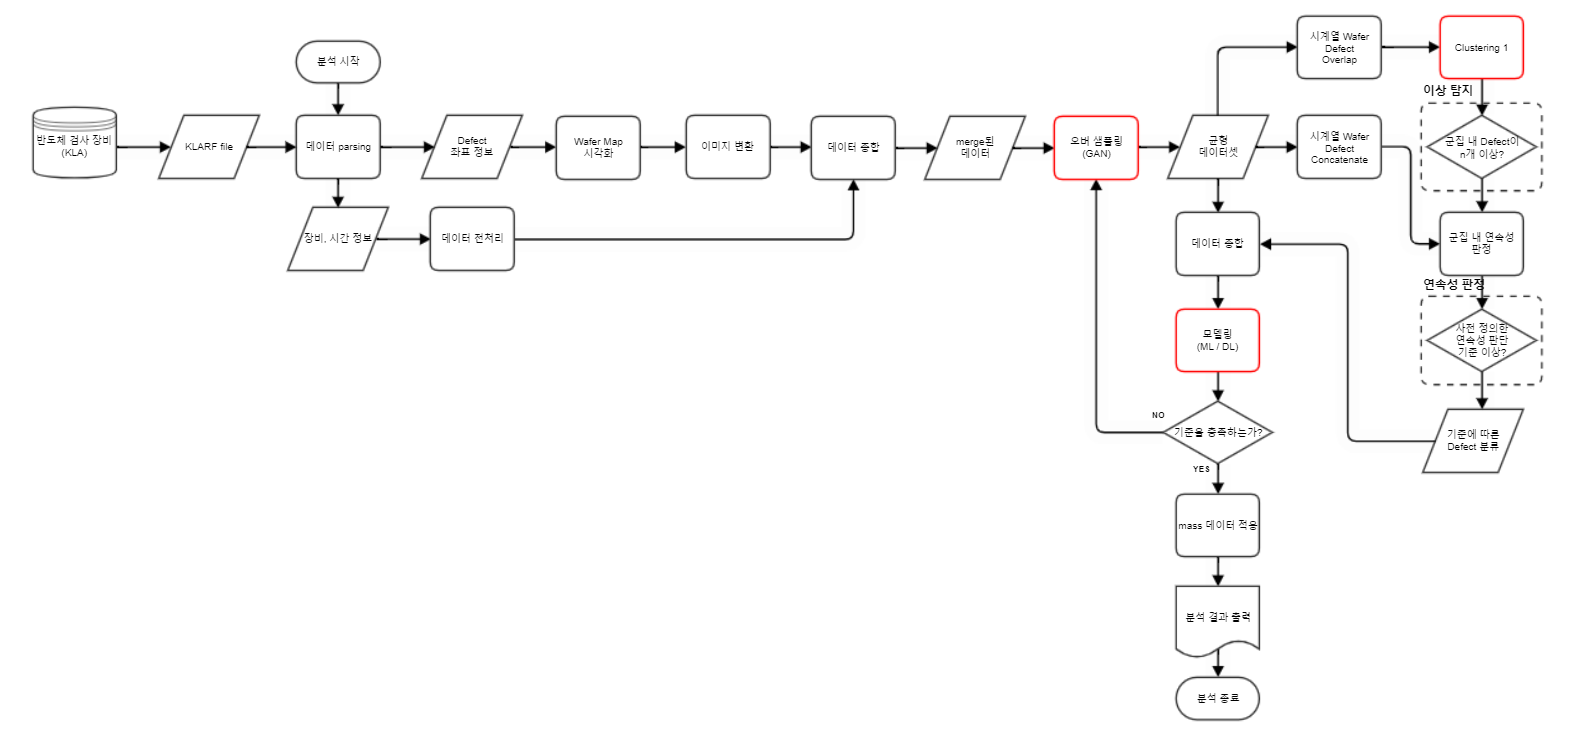

In [2]:
# import 
import pandas as pd
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.cm as cm
import seaborn as sns

import os, glob, joblib
from tqdm import tqdm
from datetime import datetime
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score ,roc_curve, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

---
## KLARF file parsing

In [2]:
file_path = glob.glob("klarfsample/*")

len(file_path)

1000

In [3]:
# 실행할 때마다 한 줄씩 읽어오기
# readlines()로 한번에 시도하면, 용량이 큰 파일의 경우엔 out of memory 가능성.

def readfile(file_path):
    readlines = []
    with open(file_path, 'r') as f:
        i = 1
        while True:
            line = f.readline()
            if not line:
                break
            line = str(i) + ' ' + line
            readlines.append(line.strip('\n').strip(';').split(' '))
            i += 1    
    return readlines

readfile(file_path[0])

[['1', 'FileVersion', '1', '1'],
 ['2', 'FileTimestamp', '01-01-23', '21:16:19'],
 ['3', 'TiffSpec', '6.0', 'G', 'R'],
 ['4',
  'InspectionStationID',
  '"ASAC',
  'TECHNOLOGY',
  'INC"',
  '"A3D02"',
  '"A3D02"'],
 ['5', 'SampleType', 'WAFER'],
 ['6', 'ResultTimestamp', '01-01-23', '21:16:19'],
 ['7', 'LotID', '"AS10330WP"'],
 ['8', 'SampleSize', '1', '300'],
 ['9', 'DeviceID', '"AC1"'],
 ['10', 'SetupID', '"Metrology-Type-01"', '01-01-23', '21:16:19'],
 ['11', 'StepID', '"Metrology-Type-01"'],
 ['12', 'SampleOrientationMarkType', 'NOTCH'],
 ['13', 'OrientationMarkLocation', 'DOWN'],
 ['14', 'TiffFilename', 'AS10330WP_AS10330-14_01-01-23_83.tif'],
 ['15', 'DiePitch', '9.308326e+003', '8.178364e+003'],
 ['16', 'DiePitch', '8.000000e+003', '8.000000e+003'],
 ['17', 'WaferID', '', '"14"'],
 ['18', 'Slot', '14'],
 ['19', 'SampleCenterLocation', '0.000', '0.000'],
 ['20', 'InspectionTest', '1'],
 ['21', 'SampleTestPlan', '536'],
 ['22', '18', '26'],
 ['23', '17', '26'],
 ['24', '16', '26']

### KLARF file의 설비, 제품 및 시간에 대한 데이터 parsing

In [4]:
# KLARF file로부터 데이터 parsing
temp_df = pd.DataFrame()
fname = []
for i, fp in enumerate(file_path):
    dict_klarf = {}
    for line in readfile(fp):
        if not line[1].isnumeric():
            dict_klarf[line[1]] = ' '.join(line[2:])
    fname.append(os.path.split(fp)[1].split('.')[0])
    temp = pd.DataFrame(dict_klarf, index=[i])
    temp_df = pd.concat([temp_df, temp])


temp_df['FileName'] = fname
cols = ['FileName']
cols.extend(temp_df.columns[:-1])

temp_df = temp_df[cols]
temp_df.head(3)

,FileName,FileVersion,FileTimestamp,TiffSpec,InspectionStationID,SampleType,ResultTimestamp,LotID,SampleSize,DeviceID,...,Slot,SampleCenterLocation,InspectionTest,SampleTestPlan,AreaPerTest,DefectRecordSpec,DefectList,SummarySpec,SummaryList,EndOfFile
0,AS10330WP_AS10330-14_01-01-23_83,1 1,01-01-23 21:16:19,6.0 G R,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""",WAFER,01-01-23 21:16:19,"""AS10330WP""",1 300,"""AC1""",...,14,0.000 0.000,1,536,4.978698e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,
1,AS10103S1_AS10103-14_01-06-23_578,1 1,01-06-23 05:35:07,6.0 G R,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""",WAFER,01-06-23 05:35:07,"""AS10103S1""",1 300,"""AS1""",...,14,0.000 0.000,1,536,4.978698e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,
2,AC10022T_AC10022-02_01-07-23_780,1 1,01-07-23 23:14:07,6.0 G R,"""ASAC TECHNOLOGY INC"" ""A3D01"" ""A3D01""",WAFER,01-07-23 23:14:07,"""AC10022T""",1 300,"""AC1""",...,02,0.000 0.000,1,536,4.978698e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,


In [5]:
# unique값이 1인 columns 정리
singleCols = []
for col in temp_df.columns:
    if len(temp_df[col].unique()) == 1:
        singleCols.append(col)
        print('==='*20)
        print(col)
        print(temp_df[col].unique())
    
# 위에서 정리한 columns에 이미 dataframe으로 만든 DefectList, SummaryList columns 추가
singleCols.extend(["DefectList", "SummaryList"])

FileVersion
['1 1']
TiffSpec
['6.0 G R']
SampleType
['WAFER']
SampleSize
['1 300']
SampleOrientationMarkType
['NOTCH']
OrientationMarkLocation
['DOWN']
DiePitch
['8.000000e+003 8.000000e+003']
SampleCenterLocation
['0.000 0.000']
InspectionTest
['1']
SampleTestPlan
['536']
AreaPerTest
['4.978698e+010']
DefectRecordSpec
['17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZE DEFECTAREA DSIZE CLASSNUMBER TEST CLUSTERNUMBER ROUGHBINNUMBER FINEBINNUMBER REVIEWSAMPLE IMAGECOUNT IMAGELIST']
DefectList
['']
SummarySpec
['5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE']
SummaryList
['']
EndOfFile
['']


In [6]:
# 단일 원소를 가진 columns 제거.
temp_df.drop(columns=singleCols, inplace=True)

In [7]:
# column 비교 후 제거 함수
# 보존할 column = col1
# 제거할 column = col2
def eliminate(df, col1, col2):
    '''
    col1: 남길 컬럼
    col2: 제거할 컬럼
    '''
    if df[df[col1] != df[col2]].size == 0:
        df.drop(columns=col2, inplace=True)
        print(f'"{col2}" Column 제거됨.')
    return df

# FileTimestamp column과 ResultTimestamp column이 동일하면 해당 컬럼 삭제
temp_df = eliminate(temp_df, "FileTimestamp", "ResultTimestamp")
temp_df.head(3)

"ResultTimestamp" Column 제거됨.


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID,Slot
0,AS10330WP_AS10330-14_01-01-23_83,01-01-23 21:16:19,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""","""AS10330WP""","""AC1""","""Metrology-Type-01"" 01-01-23 21:16:19","""Metrology-Type-01""",AS10330WP_AS10330-14_01-01-23_83.tif,"""14""",14
1,AS10103S1_AS10103-14_01-06-23_578,01-06-23 05:35:07,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""","""AS10103S1""","""AS1""","""Metrology-Type-01"" 01-06-23 05:35:07","""Metrology-Type-01""",AS10103S1_AS10103-14_01-06-23_578.tif,"""14""",14
2,AC10022T_AC10022-02_01-07-23_780,01-07-23 23:14:07,"""ASAC TECHNOLOGY INC"" ""A3D01"" ""A3D01""","""AC10022T""","""AC1""","""Metrology-Type-02"" 01-07-23 23:14:07","""Metrology-Type-02""",AC10022T_AC10022-02_01-07-23_780.tif,"""02""",02


In [8]:
# temp_df의 FileTimestamp를 datetime형으로 변환
# 현재 %m-%d-%y %H:%M:%S 형태로 되어있음. 이를 %Y-%m-%d %H:%M:%S

temp_df.FileTimestamp = temp_df.FileTimestamp.apply(lambda x: datetime.strptime(x, "%m-%d-%y %H:%M:%S"))
temp_df.head(3)

,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID,Slot
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""","""AS10330WP""","""AC1""","""Metrology-Type-01"" 01-01-23 21:16:19","""Metrology-Type-01""",AS10330WP_AS10330-14_01-01-23_83.tif,"""14""",14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""","""AS10103S1""","""AS1""","""Metrology-Type-01"" 01-06-23 05:35:07","""Metrology-Type-01""",AS10103S1_AS10103-14_01-06-23_578.tif,"""14""",14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,"""ASAC TECHNOLOGY INC"" ""A3D01"" ""A3D01""","""AC10022T""","""AC1""","""Metrology-Type-02"" 01-07-23 23:14:07","""Metrology-Type-02""",AC10022T_AC10022-02_01-07-23_780.tif,"""02""",02


In [9]:
# InspectionStationID column
print(temp_df.InspectionStationID.unique())

# A3D01, A3D02로 요약할 수 있음.
temp_df.InspectionStationID = temp_df.InspectionStationID.apply(lambda x: x.strip('"').split('" "')[-1])
temp_df.head(3)

['"ASAC TECHNOLOGY INC" "A3D02" "A3D02"'
 '"ASAC TECHNOLOGY INC" "A3D01" "A3D01"']


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID,Slot
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,"""AS10330WP""","""AC1""","""Metrology-Type-01"" 01-01-23 21:16:19","""Metrology-Type-01""",AS10330WP_AS10330-14_01-01-23_83.tif,"""14""",14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,"""AS10103S1""","""AS1""","""Metrology-Type-01"" 01-06-23 05:35:07","""Metrology-Type-01""",AS10103S1_AS10103-14_01-06-23_578.tif,"""14""",14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,"""AC10022T""","""AC1""","""Metrology-Type-02"" 01-07-23 23:14:07","""Metrology-Type-02""",AC10022T_AC10022-02_01-07-23_780.tif,"""02""",02


In [10]:
# "LotID", "DeviceID", "StepID", "WaferID" columns에 대해 " " 제거
temp_df[["LotID", "DeviceID", "StepID", "WaferID"]] = \
    temp_df[["LotID", "DeviceID", "StepID", "WaferID"]].applymap(lambda x: x.strip(' "'))
temp_df.head(3)

,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID,Slot
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,"""Metrology-Type-01"" 01-01-23 21:16:19",Metrology-Type-01,AS10330WP_AS10330-14_01-01-23_83.tif,14,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,"""Metrology-Type-01"" 01-06-23 05:35:07",Metrology-Type-01,AS10103S1_AS10103-14_01-06-23_578.tif,14,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,"""Metrology-Type-02"" 01-07-23 23:14:07",Metrology-Type-02,AC10022T_AC10022-02_01-07-23_780.tif,02,02


In [11]:
# WaferID column과 Slot column이 동일한지 확인.
# 동일하면 Slot column 제거
# 동일하지 않다면, Fab에 문제가 생긴것..

temp_df = eliminate(temp_df, "WaferID", "Slot")
temp_df.head(3)

"Slot" Column 제거됨.


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,"""Metrology-Type-01"" 01-01-23 21:16:19",Metrology-Type-01,AS10330WP_AS10330-14_01-01-23_83.tif,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,"""Metrology-Type-01"" 01-06-23 05:35:07",Metrology-Type-01,AS10103S1_AS10103-14_01-06-23_578.tif,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,"""Metrology-Type-02"" 01-07-23 23:14:07",Metrology-Type-02,AC10022T_AC10022-02_01-07-23_780.tif,02


In [12]:
# SetupID column에서 timestamp가 FileTimestamp와 일치하는지 확인.
# 완벽히 일치한다면 해당 timestamp만 제거.
if temp_df[temp_df.SetupID.apply(lambda x: datetime.strptime(x.split('"')[2].strip(' '), "%m-%d-%y %H:%M:%S"))
        != temp_df.FileTimestamp].size == 0:
    temp_df.SetupID = temp_df.SetupID.apply(lambda x: x.split('"')[1])
    print('timestamp 제거됨.')
temp_df.head(3)

timestamp 제거됨.


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,Metrology-Type-01,AS10330WP_AS10330-14_01-01-23_83.tif,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,Metrology-Type-01,AS10103S1_AS10103-14_01-06-23_578.tif,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,Metrology-Type-02,AC10022T_AC10022-02_01-07-23_780.tif,02


In [13]:
# 수정된 SetupID column에서 Metrology-Type이 StepID와 일치하는지 확인.
# 완벽히 일치한다면 해당 column 제거.
temp_df = eliminate(temp_df, 'StepID', 'SetupID')
temp_df.head(3)

"SetupID" Column 제거됨.


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,StepID,TiffFilename,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,AS10330WP_AS10330-14_01-01-23_83.tif,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,AS10103S1_AS10103-14_01-06-23_578.tif,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,AC10022T_AC10022-02_01-07-23_780.tif,02


In [14]:
# StepID column 종류 확인.
temp_df.StepID.unique()

array(['Metrology-Type-01', 'Metrology-Type-02', 'Metrology-type-01',
       'Metrology-type-02'], dtype=object)

In [15]:
# StepID의 column 통일
temp_df.StepID = temp_df.StepID.apply(lambda x: x.split('-')[0]
                                      + '-T' + x.split('-')[1][1:]
                                      + '-' + x.split('-')[2])
temp_df.head(3)

,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,StepID,TiffFilename,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,AS10330WP_AS10330-14_01-01-23_83.tif,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,AS10103S1_AS10103-14_01-06-23_578.tif,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,AC10022T_AC10022-02_01-07-23_780.tif,02


In [16]:
# TiffFilename column이 FileName column과 일치하면 제거.
temp_df[["FileName", "TiffFilename"]] = temp_df[["FileName", "TiffFilename"]].applymap(lambda x: x.split('.')[0])
temp_df = eliminate(temp_df, "FileName", "TiffFilename")
temp_df.head(3)

"TiffFilename" Column 제거됨.


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,StepID,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,02


In [17]:
# WaferID에 LotID 정보 추가
temp_df.WaferID = temp_df.LotID.apply(lambda x: re.split('\d+', x)[0]+re.split('\D+', x)[1]) + '-' + temp_df.WaferID
temp_df.head(3)

,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,StepID,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,AS10330-14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,AS10103-14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,AC10022-02


In [18]:
# columns 이름 변경
# FileTimestamp -> Timestamp
# InspectionStationID -> MachineID
temp_df.rename(columns={'FileTimestamp': 'Timestamp',
                        'InspectionStationID': 'MachineID'}, inplace=True)
temp_df.head(3)

,FileName,Timestamp,MachineID,LotID,DeviceID,StepID,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,AS10330-14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,AS10103-14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,AC10022-02


In [19]:
# columns 순서 변경
newcols = ['FileName', 'LotID', 'WaferID', 'Timestamp', 'MachineID', 'StepID', 'DeviceID']
temp_df = temp_df[newcols]
temp_df.head(3)

,FileName,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID
0,AS10330WP_AS10330-14_01-01-23_83,AS10330WP,AS10330-14,2023-01-01 21:16:19,A3D02,Metrology-Type-01,AC1
1,AS10103S1_AS10103-14_01-06-23_578,AS10103S1,AS10103-14,2023-01-06 05:35:07,A3D02,Metrology-Type-01,AS1
2,AC10022T_AC10022-02_01-07-23_780,AC10022T,AC10022-02,2023-01-07 23:14:07,A3D01,Metrology-Type-02,AC1


In [20]:
# timestamp 순으로 정렬
temp_df = temp_df.sort_values('Timestamp').reset_index(drop=True)
temp_df.head()

,FileName,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID
0,AC10002SA_AC10002-01_01-01-23_1,AC10002SA,AC10002-01,2023-01-01 04:10:00,A3D02,Metrology-Type-01,AC1
1,AS10001T_AS10001-01_01-01-23_2,AS10001T,AS10001-01,2023-01-01 04:12:49,A3D01,Metrology-Type-01,AS1
2,AS10001T_AS10001-02_01-01-23_3,AS10001T,AS10001-02,2023-01-01 04:38:19,A3D01,Metrology-Type-01,AS1
3,AC10002SA_AC10002-03_01-01-23_4,AC10002SA,AC10002-03,2023-01-01 04:41:51,A3D02,Metrology-Type-01,AC1
4,AS10001T_AS10001-03_01-01-23_5,AS10001T,AS10001-03,2023-01-01 04:55:52,A3D01,Metrology-Type-01,AS1


### Wafer Map Visuallization

In [21]:
# Wafer Map Frame을 생성하기 위한 좌표 추출
readlines = readfile(file_path[0])
for line in readlines:
    if line[1] == 'SampleTestPlan':
        firstRow = int(line[0])
        print(f'firstRow: {firstRow}')
    elif line[1] == 'AreaPerTest':
        lastRow = int(line[0]) - 2
        print(f'lastRow: {lastRow}')
        
wafer_x_coordinate = [int(line[1]) for line in readlines[firstRow:lastRow+1]]
wafer_y_coordinate = [int(line[2]) for line in readlines[firstRow:lastRow+1]]

print(f'x_min: {min(wafer_x_coordinate)}, x_max: {max(wafer_x_coordinate)}')
print(f'y_min: {min(wafer_y_coordinate)}, y_max: {max(wafer_y_coordinate)}')

firstRow: 21
lastRow: 556
x_min: 1, x_max: 24
y_min: 1, y_max: 26


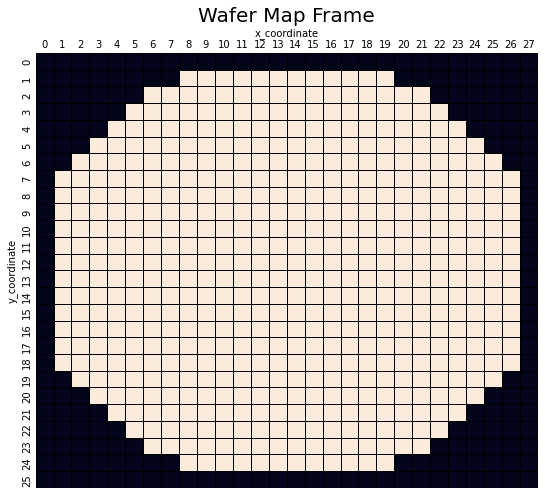

In [22]:
base_wafer = np.zeros([max(wafer_x_coordinate)+2, max(wafer_y_coordinate)+2])
for x,y in zip(wafer_x_coordinate, wafer_y_coordinate):
    base_wafer[x,y] = 1

def visualization_wafer(map, size, title):
    plt.figure(figsize=(size+1,size))
    ax = sns.heatmap(map, linewidths=1, linecolor='black', cbar=False)
    plt.xlabel("x_coordinate")
    plt.ylabel("y_coordinate")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.title(title, fontsize=20)
    plt.show()
    
visualization_wafer(base_wafer, 8, "Wafer Map Frame")

In [23]:
# DefectList를 dataframe으로 변환.
defectList = []
for fp in tqdm(file_path):
    readlines = readfile(fp)
    for line in readlines:
        if line[1] == 'DefectList':
            defectRow = int(line[0])
        elif line[1] == 'SummarySpec':
            defectRowEND = int(line[0]) - 1
        else:
            continue
        
    defectCols = ['FILE']
    defectCols.extend(readlines[defectRow-2][3:])
    
    if readlines[defectRow][1].isnumeric():
        for line in readlines[defectRow:defectRowEND]:
            if len(line) == 18:
                temp = [os.path.split(fp)[1]]
                temp.extend(line[1:])
                defectList.append(temp)
    else:
        temp = [os.path.split(fp)[1]]
        temp.extend(np.zeros(17).tolist())
        defectList.append(temp)

temp_defectDF = pd.DataFrame(data=defectList, columns=defectCols)
temp_defectDF[["XINDEX", "YINDEX"]] = temp_defectDF[["XINDEX", "YINDEX"]].astype('int')
temp_defectDF.head()

100%|██████████| 1000/1000 [00:00<00:00, 4208.62it/s]


,FILE,DEFECTID,XREL,YREL,XINDEX,YINDEX,XSIZE,YSIZE,DEFECTAREA,DSIZE,CLASSNUMBER,TEST,CLUSTERNUMBER,ROUGHBINNUMBER,FINEBINNUMBER,REVIEWSAMPLE,IMAGECOUNT,IMAGELIST
0,AS10330WP_AS10330-14_01-01-23_83.001,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AS10103S1_AS10103-14_01-06-23_578.001,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AC10022T_AC10022-02_01-07-23_780.001,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AS10016TK_AS10016-17_01-07-23_731.001,1,1.5e+01,2.826e+03,2,1,499.077,502.606,0,0.000000,232,1,0,100,0,0,2,2
4,AC10010S1_AC10010-07_01-03-23_297.001,1,5.98e+03,5.289e+03,8,2,506.242,488.036,0,0.000000,232,1,0,100,0,0,2,2


In [24]:
# Summary Spec.을 DataFrame으로 변환

summarySpec = []
for fp in tqdm(file_path):
    readlines = readfile(fp)
    for line in readlines:
        if line[1] == 'SummarySpec':
            summaryRow = int(line[0])
            
    summaryCols = ['FILE']
    summaryCols.extend(readlines[summaryRow-1][3:])
    if readlines[summaryRow+1][1].isnumeric():
        temp = [os.path.split(fp)[1]]
        temp.extend(readlines[summaryRow+1][1:])
        summarySpec.append(temp)
    else:
        temp = [os.path.split(fp)[1]]
        temp.extend(np.zeros(5).tolist())
        summarySpec.append(temp)

summary_df = pd.DataFrame(data=summarySpec, columns=summaryCols, index=np.arange(1000))
summary_df.head()

100%|██████████| 1000/1000 [00:00<00:00, 4019.27it/s]


,FILE,TESTNO,NDEFECT,DEFDENSITY,NDIE,NDEFDIE
0,AS10330WP_AS10330-14_01-01-23_83.001,1,0,1.000,536,0
1,AS10103S1_AS10103-14_01-06-23_578.001,1,0,1.000,536,0
2,AC10022T_AC10022-02_01-07-23_780.001,1,0,1.000,536,0
3,AS10016TK_AS10016-17_01-07-23_731.001,1,1,1.000,535,1
4,AC10010S1_AC10010-07_01-03-23_297.001,1,1,1.000,535,1


In [25]:
# defect_df와 summary_df merge
defect_df = pd.merge(summary_df, temp_defectDF, how='inner', left_on='FILE', right_on='FILE')
defect_df.head()

,FILE,TESTNO,NDEFECT,DEFDENSITY,NDIE,NDEFDIE,DEFECTID,XREL,YREL,XINDEX,...,DEFECTAREA,DSIZE,CLASSNUMBER,TEST,CLUSTERNUMBER,ROUGHBINNUMBER,FINEBINNUMBER,REVIEWSAMPLE,IMAGECOUNT,IMAGELIST
0,AS10330WP_AS10330-14_01-01-23_83.001,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AS10103S1_AS10103-14_01-06-23_578.001,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AC10022T_AC10022-02_01-07-23_780.001,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AS10016TK_AS10016-17_01-07-23_731.001,1,1,1.000,535,1,1,1.5e+01,2.826e+03,2,...,0,0.000000,232,1,0,100,0,0,2,2
4,AC10010S1_AC10010-07_01-03-23_297.001,1,1,1.000,535,1,1,5.98e+03,5.289e+03,8,...,0,0.000000,232,1,0,100,0,0,2,2


In [26]:
# defect_df의 FILE columns 변경
defect_df.FILE = defect_df.FILE.apply(lambda x: x.split('.')[0])

In [27]:
defect_df.NDEFECT.isna().sum()

0

In [28]:
defect_df.NDEFECT.unique()

array(['0', '1', '2'], dtype=object)

In [29]:
defect_df.DEFECTID.unique()

array([0.0, '1'], dtype=object)

In [30]:
defect_df.CLASSNUMBER.unique()

array([0.0, '232'], dtype=object)

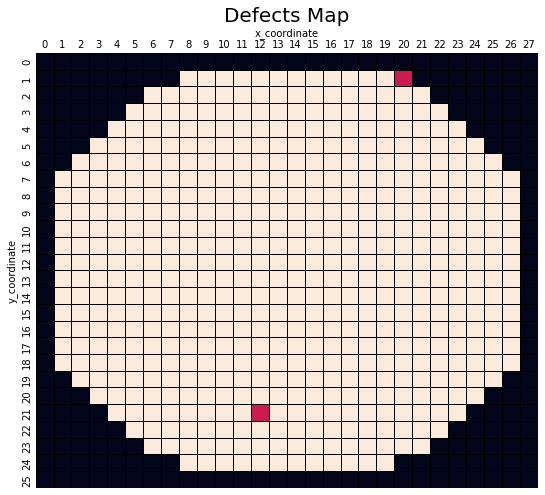

In [31]:
# defect 시각화
defectMaps=[]
for fp in file_path:
    base = base_wafer.copy()
    filename = os.path.split(fp)[1]
    defect_x = defect_df[defect_df.FILE == filename.split('.')[0]][["XINDEX"]].astype('int').values
    defect_y = defect_df[defect_df.FILE == filename.split('.')[0]][["YINDEX"]].astype('int').values
    
    if (defect_x == 0).all():
        pass
    else:
        for i in range(defect_x.size):
            base[defect_x[i][0], defect_y[i][0]] = 0.5
    defectMaps.append(base)
    
# 임의의 defect map 시각화
visualization_wafer(defectMaps[55],8, "Defects Map")

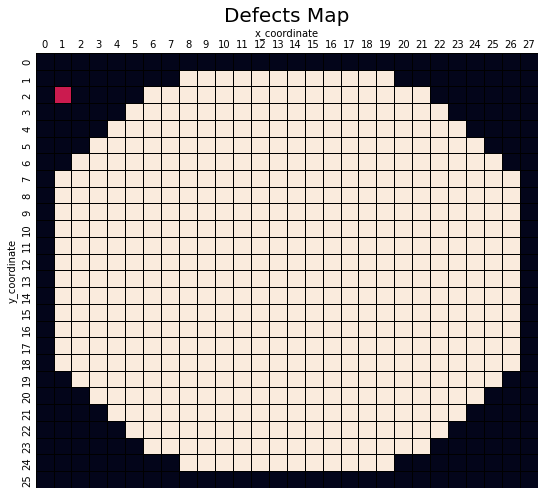

In [32]:
# defect가 wafer 영역 밖에서 표현되는 경우가 존재.
visualization_wafer(defectMaps[3],8, "Defects Map")

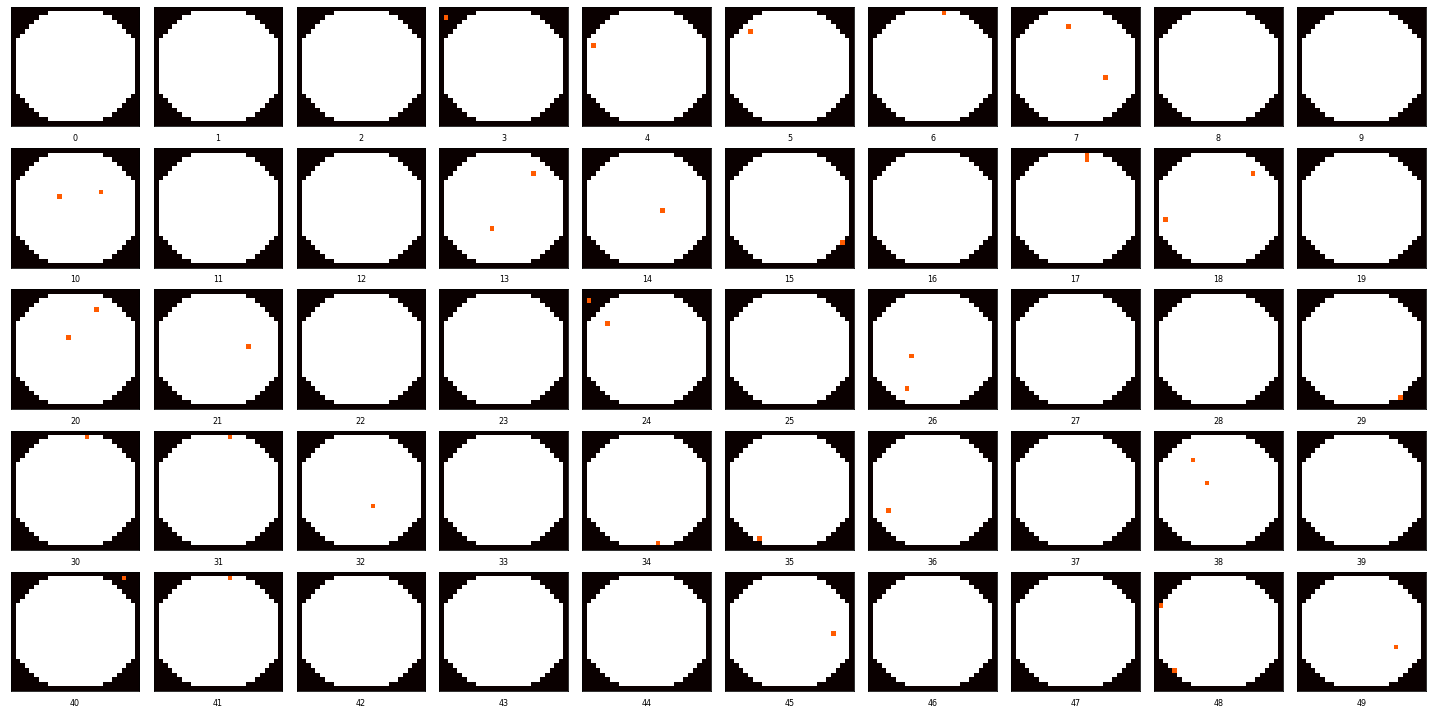

In [33]:
# 다중 wafer 시각화 (단순 추이를 보기 위함.)
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(20,10))
ax = ax.ravel(order='C')
for i in range(50):
    ax[i].imshow(defectMaps[i], cmap=cm.hot)
    ax[i].set_xlabel(f'{i}', fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

## 분석용 데이터 생성

In [34]:
temp_df.head()

,FileName,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID
0,AC10002SA_AC10002-01_01-01-23_1,AC10002SA,AC10002-01,2023-01-01 04:10:00,A3D02,Metrology-Type-01,AC1
1,AS10001T_AS10001-01_01-01-23_2,AS10001T,AS10001-01,2023-01-01 04:12:49,A3D01,Metrology-Type-01,AS1
2,AS10001T_AS10001-02_01-01-23_3,AS10001T,AS10001-02,2023-01-01 04:38:19,A3D01,Metrology-Type-01,AS1
3,AC10002SA_AC10002-03_01-01-23_4,AC10002SA,AC10002-03,2023-01-01 04:41:51,A3D02,Metrology-Type-01,AC1
4,AS10001T_AS10001-03_01-01-23_5,AS10001T,AS10001-03,2023-01-01 04:55:52,A3D01,Metrology-Type-01,AS1


In [35]:
defect_df["MAP"] = defect_df[["XINDEX", "YINDEX"]].apply(list, axis=1)
defect_df.head(3)

,FILE,TESTNO,NDEFECT,DEFDENSITY,NDIE,NDEFDIE,DEFECTID,XREL,YREL,XINDEX,...,DSIZE,CLASSNUMBER,TEST,CLUSTERNUMBER,ROUGHBINNUMBER,FINEBINNUMBER,REVIEWSAMPLE,IMAGECOUNT,IMAGELIST,MAP
0,AS10330WP_AS10330-14_01-01-23_83,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0]"
1,AS10103S1_AS10103-14_01-06-23_578,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0]"
2,AC10022T_AC10022-02_01-07-23_780,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0]"


In [36]:
def appendFn(*listset):
    lst = []
    for list_ in listset:
        lst.append(list_)
    return lst

defect_temp = defect_df.groupby(['FILE'])["MAP"].apply(appendFn).reset_index()
defect_temp.MAP = defect_temp.MAP.apply(lambda x: np.array(x).squeeze(0))
defect_temp

,FILE,MAP
0,AC10001TA_AC10001-01_01-01-23_41,"[[24, 20]]"
1,AC10001TA_AC10001-02_01-01-23_43,"[[15, 17]]"
2,AC10001TA_AC10001-03_01-01-23_45,"[[0, 0]]"
3,AC10001TA_AC10001-04_01-01-23_47,"[[0, 0]]"
4,AC10001TA_AC10001-05_01-01-23_49,"[[16, 21]]"
...,...,...
995,AS20300S_AS20300-21_01-07-23_690,"[[0, 0]]"
996,AS20300S_AS20300-22_01-07-23_692,"[[0, 0]]"
997,AS20300S_AS20300-23_01-07-23_693,"[[8, 5]]"
998,AS20300S_AS20300-24_01-07-23_695,"[[0, 0]]"


In [37]:
df = pd.merge(temp_df, defect_temp, how='inner', left_on='FileName', right_on='FILE').drop(columns=["FILE", "FileName"])
df.head()

,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID,MAP
0,AC10002SA,AC10002-01,2023-01-01 04:10:00,A3D02,Metrology-Type-01,AC1,"[[0, 0]]"
1,AS10001T,AS10001-01,2023-01-01 04:12:49,A3D01,Metrology-Type-01,AS1,"[[16, 15]]"
2,AS10001T,AS10001-02,2023-01-01 04:38:19,A3D01,Metrology-Type-01,AS1,"[[0, 0]]"
3,AC10002SA,AC10002-03,2023-01-01 04:41:51,A3D02,Metrology-Type-01,AC1,"[[0, 0]]"
4,AS10001T,AS10001-03,2023-01-01 04:55:52,A3D01,Metrology-Type-01,AS1,"[[0, 0]]"


## 연속성 판정을 위한 Feature Engineering

1. Defects의 좌표를 거리와 각도로 표현.
2. 시계열순으로 Shift하여 데이터 batch 생성
3. 생성된 batch에 대해 Fast Fourier Transform

In [68]:
# hyperparameter
class cfg:
    seed = 1234
    n_window = 3 # 한 batch에 확인할 wafer 수 -> 10
    origin = [12.5, 13.5] # wafer의 원점 정의

In [49]:
# batch dataset visualization v2
def dist(origin, defects):
    if defects[0] == [0,0]:
        return [-1]
    distance = [-1]
    for i in range(len(defects)):
        dist = 0
        for j in range(len(defects[i])):
            dist += (origin[j]-defects[i][j])**2
        dist **= 1/2
        distance.append(int(dist))
    return distance

def theta(origin, defects):
    if defects[0] == [0,0]:
        return [-180]
    theta = [-180]
    for i in range(len(defects)):
        rc_x = defects[i][0] - origin[0]
        rc_y = defects[i][1] - origin[1]
        ang = int(np.rad2deg(np.arctan2(rc_y, rc_x)))
        theta.append(ang) # 가시성을 위해 rad -> deg
    return theta

df["Distance"] = df.MAP.apply(lambda x:dist(cfg.origin, x))
df["Degree"] = df.MAP.apply(lambda x:theta(cfg.origin, x))

In [52]:
def batch_graph(degree, distance, graph=True):
    intp = interpolate.interp1d(degree, distance, kind='linear') # linear, cubic, nearest ...
    xnew = np.arange(min(degree), max(degree), 0.1)
    
    if graph:
        fig = plt.figure(figsize=(5,2))
        plt.plot(degree, distance, "ro", xnew, intp(xnew))
        plt.xlim([-180, -180+360*cfg.n_window])
        plt.ylim([0, 20])
        xtick = np.array(degree) % 360
        plt.xticks(degree, xtick, rotation=45)
        plt.show()
    return intp, xnew

# FFT graph
def fft_graph(input, graph=True):
    Y = np.fft.fft(input)
    amp = abs(Y) * (2/len(Y))
    freq = np.fft.fftfreq(len(Y), 1/1000)

    amp = amp[0:20]
    freq = freq[0:20]
    
    if graph:
        plt.figure(figsize=(5,2))
        plt.stem(freq, amp)
        plt.grid(True)
        plt.show()
    return amp

In [54]:
# 전체 데이터에 대해 진행.
def amp_data(input):
    Y = np.fft.fft(input)
    amp = abs(Y) * (2/len(Y))
    return amp[0:20]

In [69]:
# fft그래프 visualization
def visualization_graph(df, case, graph=True):
    df["Case"] = case
    nRows = len(df) - cfg.n_window + 1
    for i in range(nRows):
        df_dist = df.Distance[i:cfg.n_window + i].tolist()
        batch_dist = []
        for dist in df_dist:
            try:
                for d in dist:
                    batch_dist.append(d)
            except:
                pass
        df_deg = df.Degree[i:cfg.n_window + i].tolist()
        batch_deg = []
        for n, deg in enumerate(df_deg):
            try:
                for d in deg:
                    batch_deg.append(d + 360*n)
            except:
                pass
        batch_dist.append(-1)    
        batch_deg.append(-180 + 360*(n+1))    
            
        print(f"Index_{df.at[i+cfg.n_window-1, 'index']}")
        intp, xnew = batch_graph(batch_deg, batch_dist, graph)
        fft_graph(intp(xnew), graph)
    return 

Case12: ('A3D01', 'Metrology-Type-01', 'AC2')
Index_455


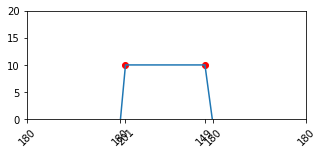

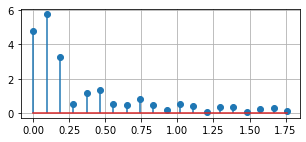

Index_456


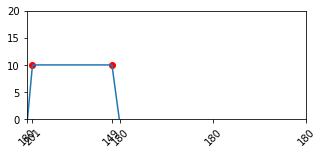

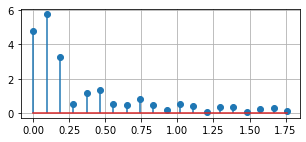

Index_458


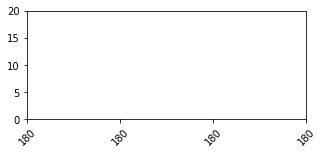

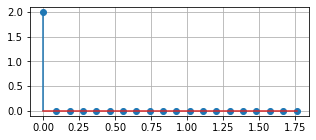

Index_461


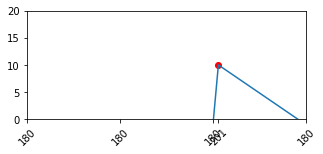

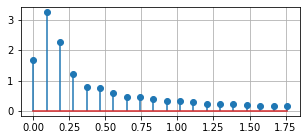

Index_463


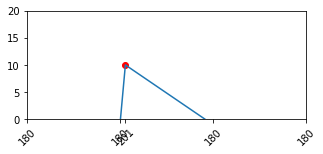

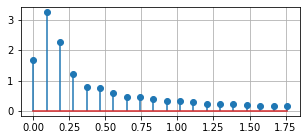

Index_465


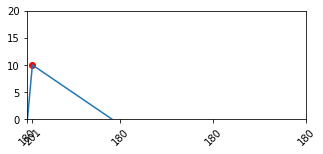

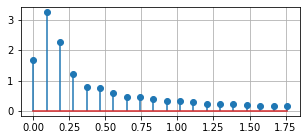

Index_467


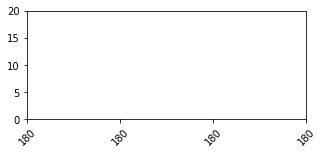

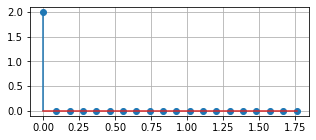

Index_469


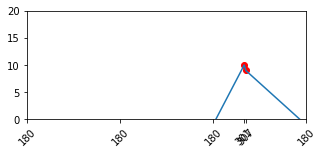

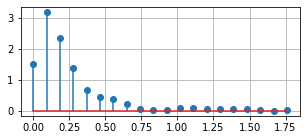

Index_471


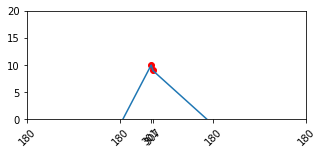

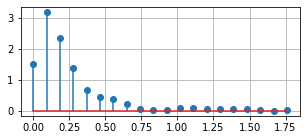

Index_473


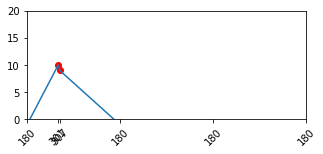

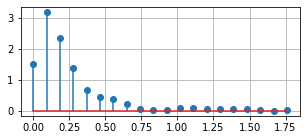

Index_475


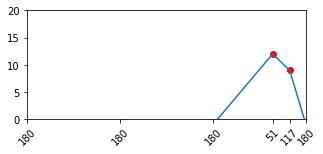

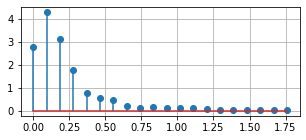

Index_477


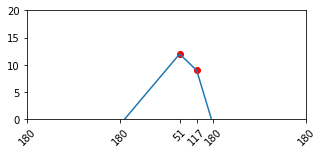

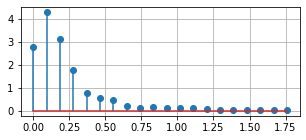

Index_478


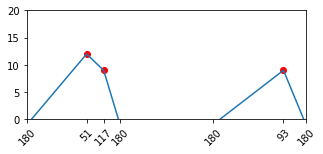

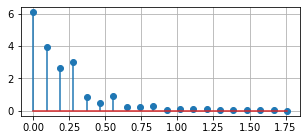

Index_480


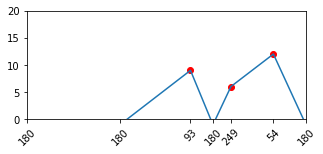

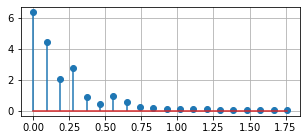

Index_482


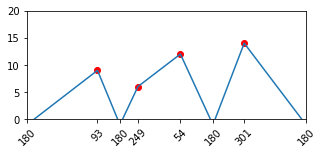

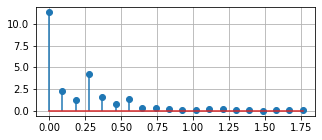

Index_484


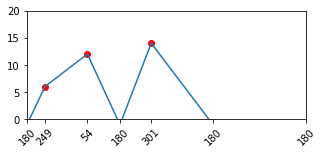

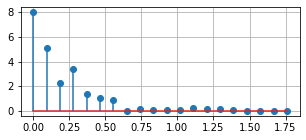

Index_485


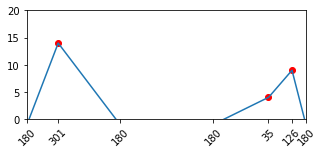

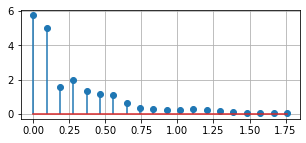

Index_487


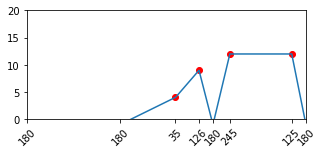

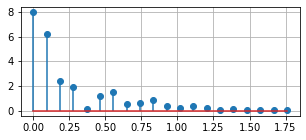

Index_489


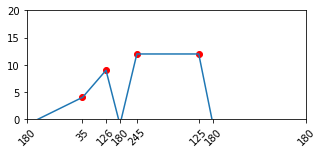

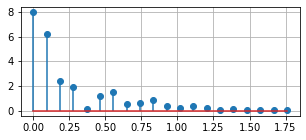

Index_491


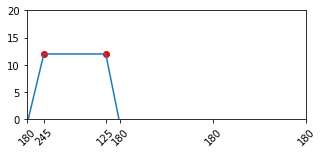

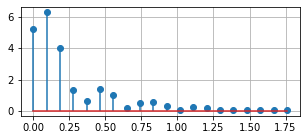

Index_494


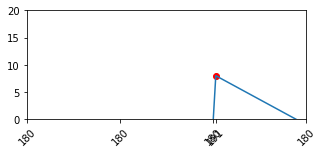

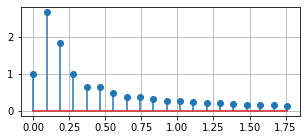

Index_496


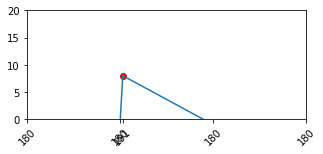

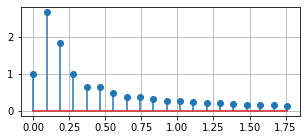

Index_497


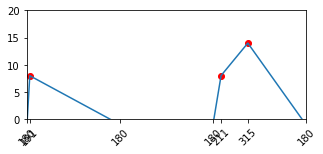

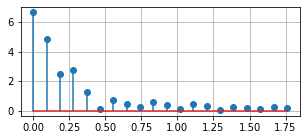

Case14: ('A3D01', 'Metrology-Type-02', 'AS1')
Index_302


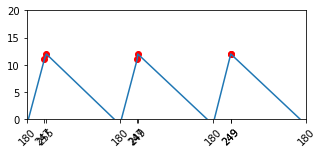

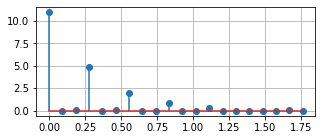

Index_304


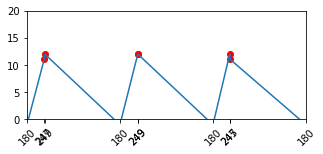

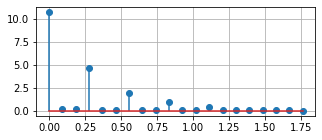

Index_306


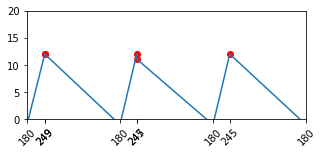

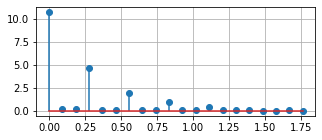

Index_308


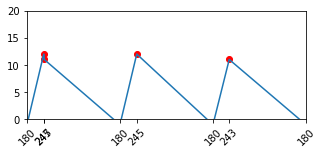

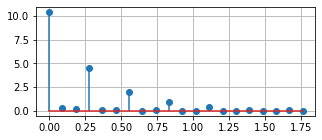

Index_401


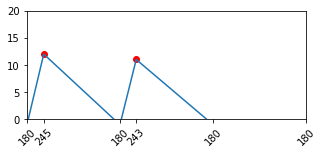

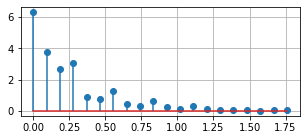

Index_403


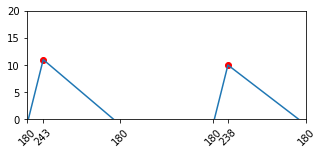

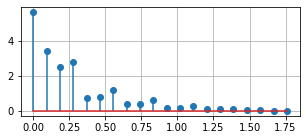

Index_405


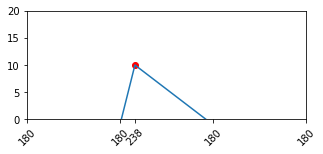

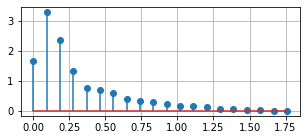

Index_407


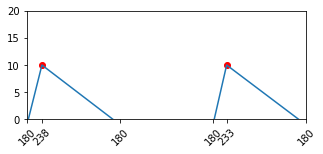

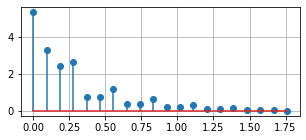

Index_409


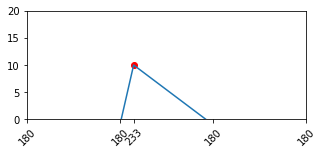

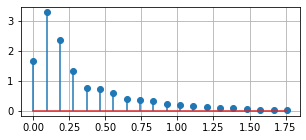

Index_411


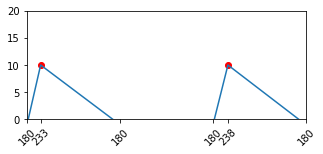

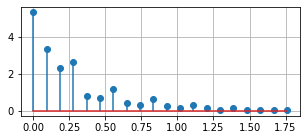

Index_413


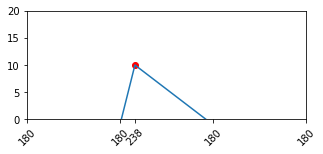

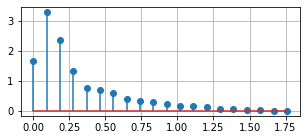

Index_415


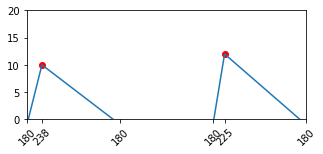

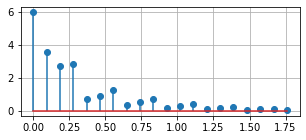

Index_417


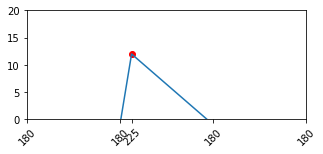

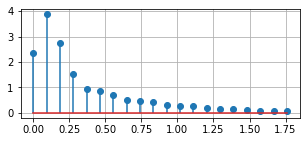

Index_419


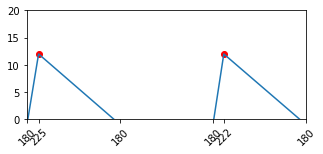

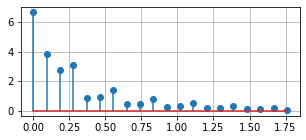

Index_421


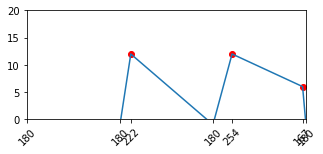

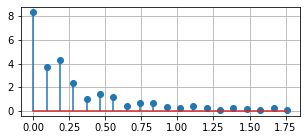

Index_423


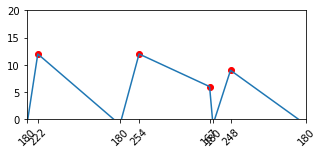

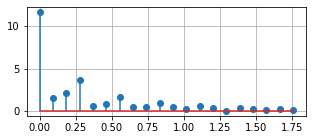

Index_425


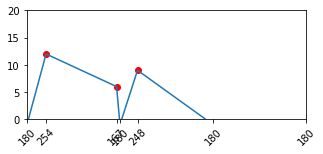

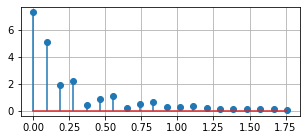

Index_428


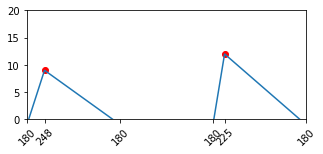

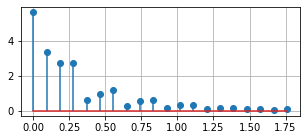

Index_430


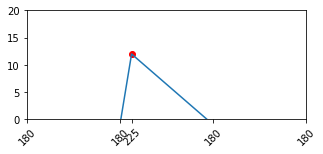

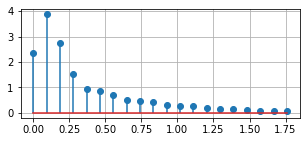

Index_432


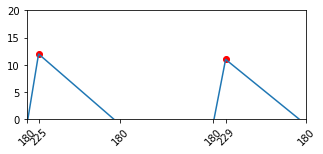

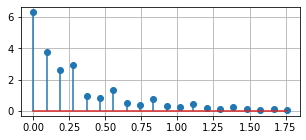

Index_434


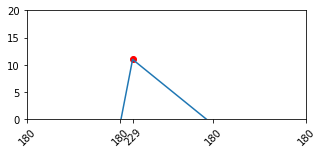

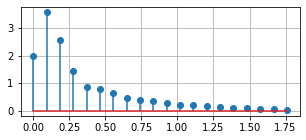

Index_436


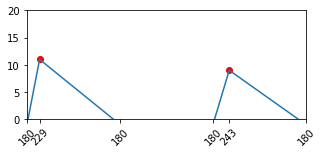

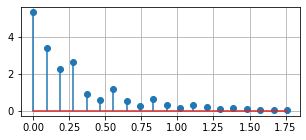

Index_438


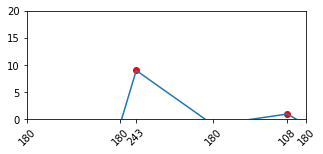

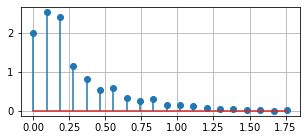

Index_440


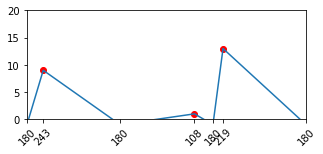

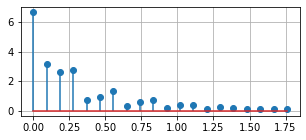

Index_441


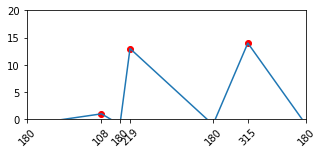

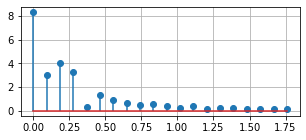

Index_443


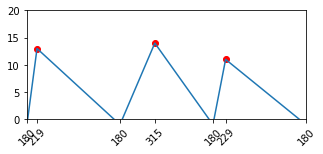

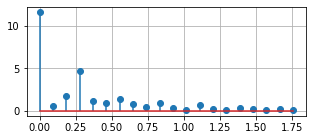

Index_445


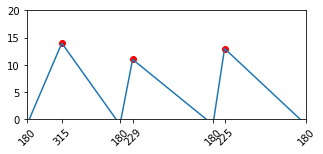

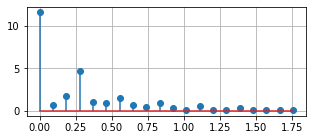

Index_447


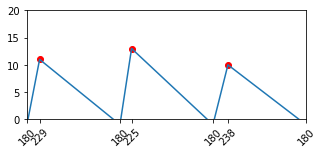

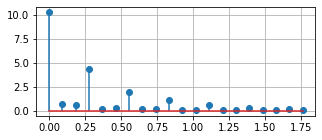

Index_449


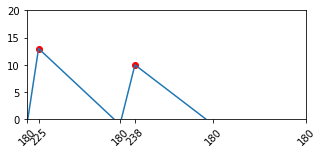

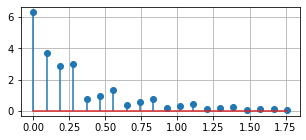

In [56]:
# 정상 / 이상 데이터에 대한 예시 그래프
machine_type = df["MachineID"].unique()
step_type = df["StepID"].unique()
device_type = df["DeviceID"].unique()

temp_df = df.copy()

case = 0
case_dict = dict()
for m in machine_type:
    for s in step_type:
        for d in device_type:
            case += 1
            if case in [12,14] :
                print("==="*30)
                print(f"Case{case}: {m,s,d}")
                case_dict["Case"+str(case)] = [m,s,d]
                    
                temp = df[(df.MachineID == m) & (df.StepID == s) & (df.DeviceID == d)].reset_index()
                if len(temp) == 0:
                    print("데이터 없음")
                    continue
                
                visualization_graph(temp, case, True)
                print("==="*30)

In [86]:
# fft후, amplitude 값 컬럼 추가
def add_amplitude(df):
    nRows = len(df) - cfg.n_window + 1
    for i in tqdm(range(nRows)):
        df_dist = df.Distance[i:cfg.n_window + i].tolist()
        batch_dist = []
        for dist in df_dist:
            try:
                for d in dist:
                    batch_dist.append(d)
            except:
                pass
            
        df_deg = df.Degree[i:cfg.n_window + i].tolist()
        batch_deg = []
        for n, deg in enumerate(df_deg):
            try:
                for d in deg:
                    batch_deg.append(d + 360*n)
            except:
                pass
        
        intp, xnew = batch_graph(batch_deg, batch_dist, False)
        df.at[i+cfg.n_window-1,"Amplitude"] = amp_data(intp(xnew)).astype('object')
    return df

In [87]:
# amplitude, case 컬럼 추가
machine_type = df["MachineID"].unique()
step_type = df["StepID"].unique()
device_type = df["DeviceID"].unique()

temp_df = pd.DataFrame()
case = 0
for m in machine_type:
    for s in step_type:
        for d in device_type:
            case += 1
            print(f"Case{case}: {m,s,d}")
            temp = df[(df.MachineID == m) & (df.StepID == s) & (df.DeviceID == d)].reset_index()
            if len(temp) == 0:
                print("데이터프레임 없음")
                continue
            
            temp = add_amplitude(temp)
            temp['Case'] = case
            temp_df = pd.concat([temp_df, temp], axis=0)
temp_df = temp_df.sort_values(by='index').reset_index(drop=True)

Case1: ('A3D02', 'Metrology-Type-01', 'AC1')


100%|██████████| 85/85 [00:00<00:00, 1955.25it/s]


Case2: ('A3D02', 'Metrology-Type-01', 'AS1')


100%|██████████| 236/236 [00:00<00:00, 2229.87it/s]


Case3: ('A3D02', 'Metrology-Type-01', 'AS2')


100%|██████████| 23/23 [00:00<00:00, 1541.70it/s]


Case4: ('A3D02', 'Metrology-Type-01', 'AC2')


100%|██████████| 73/73 [00:00<00:00, 2087.98it/s]


Case5: ('A3D02', 'Metrology-Type-02', 'AC1')
데이터프레임 없음
Case6: ('A3D02', 'Metrology-Type-02', 'AS1')


100%|██████████| 73/73 [00:00<00:00, 2106.17it/s]


Case7: ('A3D02', 'Metrology-Type-02', 'AS2')
데이터프레임 없음
Case8: ('A3D02', 'Metrology-Type-02', 'AC2')
데이터프레임 없음
Case9: ('A3D01', 'Metrology-Type-01', 'AC1')


100%|██████████| 98/98 [00:00<00:00, 1902.13it/s]


Case10: ('A3D01', 'Metrology-Type-01', 'AS1')


100%|██████████| 292/292 [00:00<00:00, 2101.03it/s]


Case11: ('A3D01', 'Metrology-Type-01', 'AS2')
데이터프레임 없음
Case12: ('A3D01', 'Metrology-Type-01', 'AC2')


100%|██████████| 23/23 [00:00<00:00, 2424.64it/s]


Case13: ('A3D01', 'Metrology-Type-02', 'AC1')


100%|██████████| 48/48 [00:00<00:00, 1701.57it/s]


Case14: ('A3D01', 'Metrology-Type-02', 'AS1')


100%|██████████| 29/29 [00:00<00:00, 1771.76it/s]

Case15: ('A3D01', 'Metrology-Type-02', 'AS2')
데이터프레임 없음
Case16: ('A3D01', 'Metrology-Type-02', 'AC2')
데이터프레임 없음


In [88]:
data = temp_df[["Amplitude", "Case"]]

# null값 제거
data = data[data.Amplitude.notnull()]
data

,Amplitude,Case
4,"[1.1365575147692653e-13, 1.6192659676815115, 0...",10
5,"[1.146801705755631, 2.96404876893771, 2.465994...",1
6,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10
7,"[4.665277777778155, 5.3708632752941865, 2.6225...",1
8,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10
...,...,...
995,"[4.626047904191197, 3.3859911884807077, 2.7075...",9
996,"[8.302561669828556, 2.244704822194835, 0.72627...",9
997,"[8.154513888887763, 2.1717257982185796, 1.5454...",9
998,"[8.176097105508994, 4.171502919051563, 1.60114...",9


In [89]:
# Class 라벨 추가
klarf_info = pd.read_csv("./klarf_scenario.txt", sep='\t')
klarf_info[klarf_info.Class != 0] = 1
temp_class = data.copy()
temp_class["Class"] = klarf_info.Class
temp_class

,Amplitude,Case,Class
4,"[1.1365575147692653e-13, 1.6192659676815115, 0...",10,0
5,"[1.146801705755631, 2.96404876893771, 2.465994...",1,0
6,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,0
7,"[4.665277777778155, 5.3708632752941865, 2.6225...",1,0
8,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,0
...,...,...,...
995,"[4.626047904191197, 3.3859911884807077, 2.7075...",9,0
996,"[8.302561669828556, 2.244704822194835, 0.72627...",9,0
997,"[8.154513888887763, 2.1717257982185796, 1.5454...",9,0
998,"[8.176097105508994, 4.171502919051563, 1.60114...",9,0


In [90]:
def make_amplitude_df(df):
    arr = np.array(df.Amplitude.iloc[0]).reshape(1,-1)
    cols = np.array([i for i in range(arr.shape[1])])
    idx = df.index
    for i in range(1,len(df)):
        arr = np.append(arr, df.Amplitude.iloc[i].reshape(1,-1), axis=0)
        
    df = pd.DataFrame(arr, columns=cols, index=idx)
    return df
make_amplitude_df(temp_class)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
4,0.0,1.619266,0.807481,0.197314,0.080493,0.058992,0.075456,0.037879,0.037047,0.017829,0.01771,0.015055,0.021369,0.009182,0.002776,0.007505,0.012868,0.005939,0.002375,0.004227
5,1.146802,2.964049,2.465994,1.790574,1.13485,0.724795,0.642353,0.63276,0.546782,0.43558,0.388714,0.389892,0.368676,0.318733,0.281846,0.275687,0.269453,0.245077,0.219866,0.213095
6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.665278,5.370863,2.622544,0.651904,0.41168,0.163603,0.158328,0.12981,0.171626,0.066428,0.007331,0.038082,0.067056,0.036145,0.040008,0.020854,0.021278,0.021244,0.032786,0.013963
8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.626048,3.385991,2.707563,2.097916,0.521773,0.382991,0.858575,0.298287,0.188737,0.355108,0.215205,0.191675,0.184119,0.161724,0.223369,0.099024,0.14715,0.177079,0.101042,0.103208
996,8.302562,2.244705,0.726275,3.156077,0.678334,0.447021,1.203226,0.53705,0.496455,0.441641,0.292955,0.345931,0.315235,0.2425,0.232462,0.304978,0.232637,0.12203,0.239633,0.205435
997,8.154514,2.171726,1.545498,2.033282,1.452728,1.988546,1.357305,0.737181,0.273186,0.464242,0.696169,0.734668,0.566909,0.227702,0.127268,0.397073,0.422123,0.437838,0.280759,0.128496
998,8.176097,4.171503,1.601143,2.386357,1.499592,0.802269,1.115865,0.546227,0.218429,0.514973,0.406374,0.242814,0.464667,0.301295,0.123114,0.262318,0.2104,0.10801,0.242477,0.206391


## FFT Amplitude 2차원/3차원 시각화

In [91]:
temp_X = make_amplitude_df(temp_class)
temp_y = temp_class[["Class"]]
temp_case = temp_class[["Case"]]

In [102]:
# 0~19까지의 컬럼에 대해 주성분분석 후, 2차원/3차원 상에 투상
from sklearn.manifold import TSNE
#temp_X = temp_X.iloc[:,1:6]
tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=cfg.seed)
tsne_X = tsne.fit_transform(temp_X)

tsne = TSNE(n_components=3, init='random', learning_rate='auto', random_state=cfg.seed)
tsne3_X = tsne.fit_transform(temp_X)

In [103]:
tsne_df = pd.DataFrame(tsne_X, index=temp_X.index, columns=['x','y'])
tsne_df = pd.concat([tsne_df, temp_y, temp_case], axis=1)

tsne3_df = pd.DataFrame(tsne3_X, index=temp_X.index, columns=['x','y','z'])
tsne3_df = pd.concat([tsne3_df, temp_y, temp_case], axis=1)

In [104]:
tsne3_df.head()

,x,y,z,Class,Case
4,3.521285,-9.732083,6.352429,0,10
5,-3.311643,-8.907175,4.880305,0,1
6,8.515121,-3.512887,10.027448,0,10
7,-5.354381,-5.903363,-6.972581,0,1
8,9.257302,-4.188636,11.708063,0,10


In [105]:
tsne_df0 = tsne_df[tsne_df.Class == 0]
tsne_df1 = tsne_df[tsne_df.Class == 1]

tsne3_df0 = tsne3_df[tsne3_df.Class == 0]
tsne3_df1 = tsne3_df[tsne3_df.Class == 1]

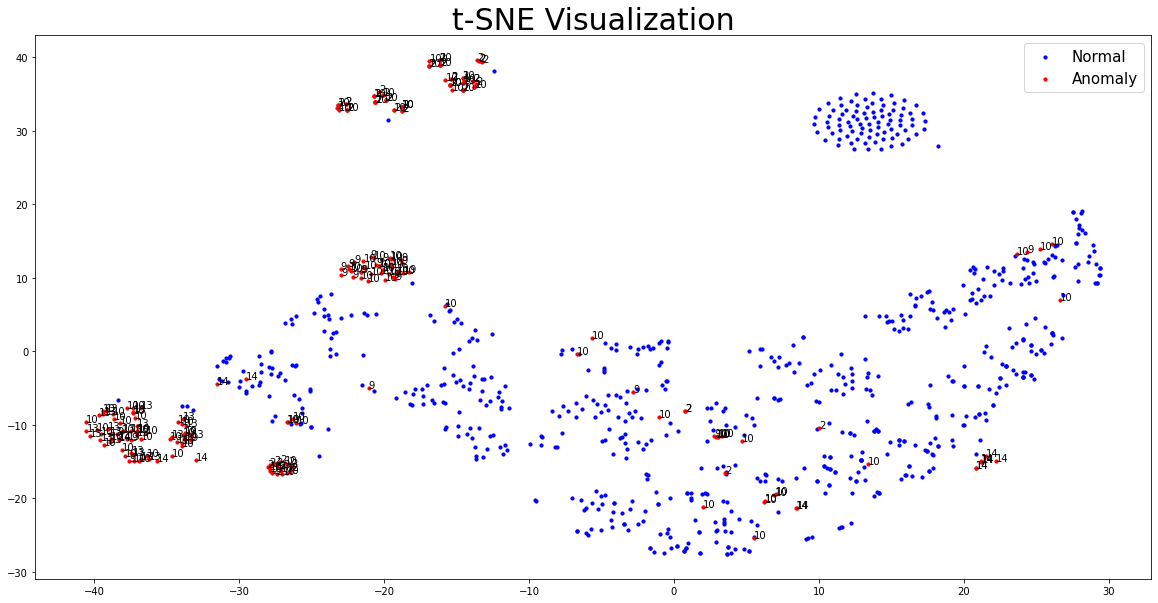

In [106]:
# 2차원 시각화
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(tsne_df0['x'], tsne_df0['y'], s=10, color='b', label='Normal')
ax.scatter(tsne_df1['x'], tsne_df1['y'], s=10, color='r', label='Anomaly')
for _, row in tsne_df1.iterrows():
    ax.text(row[0], row[1], int(row[3]))
plt.title("t-SNE Visualization", fontsize=30)
plt.legend(fontsize=15)
plt.show()

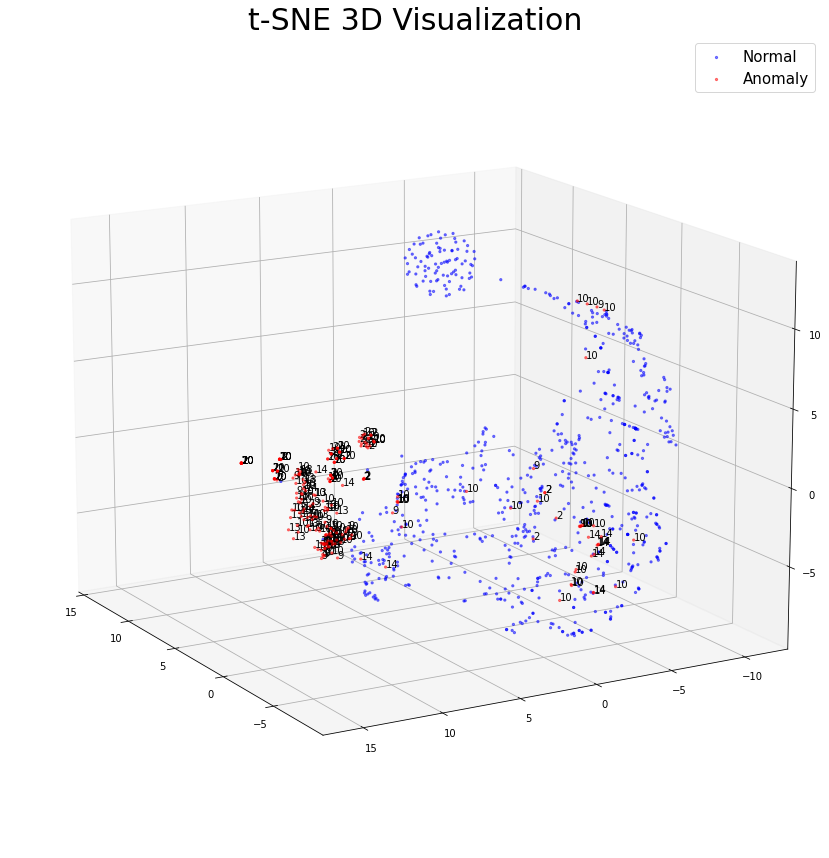

In [ ]:
# 3차원 시각화
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tsne3_df0['x'], tsne3_df0['y'], tsne3_df0['z'], s=5, color='b', alpha=0.5, label='Normal')
ax.scatter(tsne3_df1['x'], tsne3_df1['y'], tsne3_df1['z'], s=5, color='r', alpha=0.5, label='Anomaly')

for _, row in tsne3_df1.iterrows():
    ax.text(row[0], row[1], row[2], int(row[4]))
    
ax.view_init(elev=15., azim=150)
ax.legend(fontsize=15)
plt.title("t-SNE 3D Visualization", fontsize=30)
plt.show()

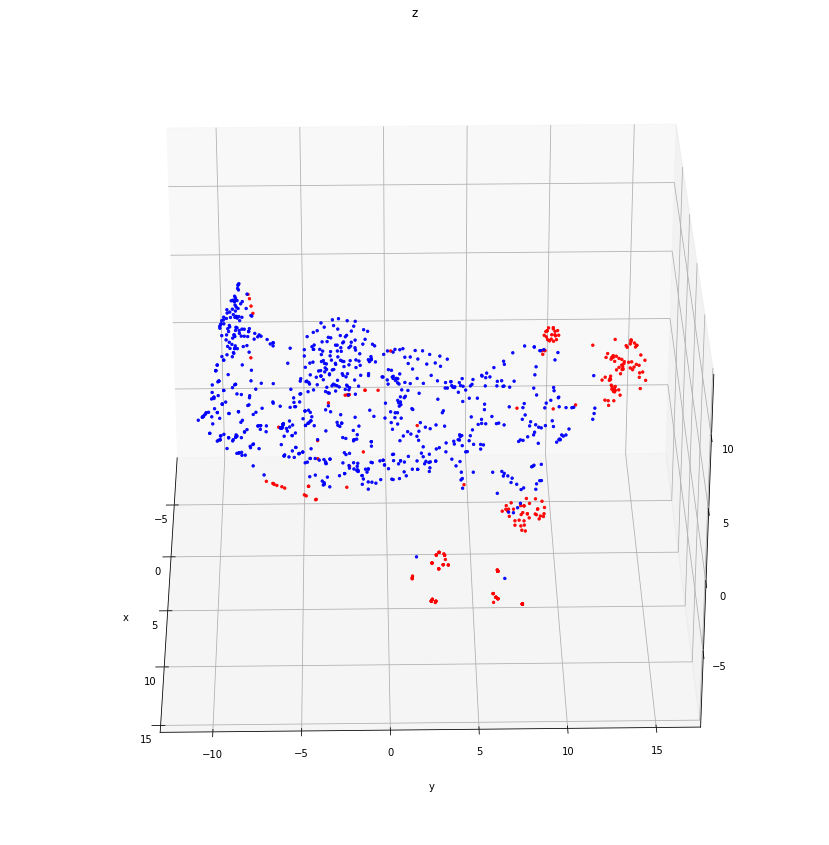

In [169]:
# 3차원 시각화 animation
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.set_xlabel("x", labelpad=16)
    ax.set_ylabel("y", labelpad=16)
    ax.set_title("z")
    
    ax.scatter(tsne3_df0["x"], tsne3_df0["y"], tsne3_df0["z"], color='b', s=5, alpha=0.5)
    ax.scatter(tsne3_df1["x"], tsne3_df1["y"], tsne3_df1["z"], color='r', s=5, alpha=0.5)
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
anim.save('3d_plot_7window.gif', fps=30)

## Classification

In [97]:
data_X = make_amplitude_df(temp_class)
data_y = temp_class[["Class"]]

train_clf_X, test_clf_X, train_clf_y ,test_clf_y = train_test_split(
    data_X, data_y, test_size=0.3, random_state=cfg.seed
)
    
rf = RandomForestClassifier(random_state=cfg.seed)
rf.fit(train_clf_X, train_clf_y)

/tmp/ipykernel_18082/3138626354.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_clf_X, train_clf_y)


RandomForestClassifier(random_state=1234)

accuracy_score: 0.952, recall score: 0.829, f1 score: 1.000


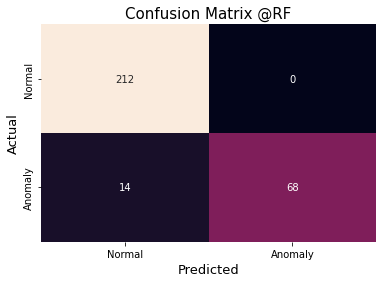

In [112]:
pred = rf.predict(test_clf_X)

acc = accuracy_score(test_clf_y, pred)
rec = recall_score(test_clf_y, pred)
pre = precision_score(test_clf_y, pred) 

print("accuracy_score: {:.3f}, recall score: {:.3f}, f1 score: {:.3f}".format(acc, rec, pre))

def plot_heatmap(actual, predicted, title):
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(actual, predicted), annot=True, fmt='d', cbar=False, ax=ax)
    ax.set_xlabel("Predicted", fontsize=13)
    ax.set_ylabel("Actual", fontsize=13)
    ax.xaxis.set_ticklabels(["Normal", "Anomaly"])
    ax.yaxis.set_ticklabels(["Normal", "Anomaly"])
    ax.set_title(title, fontsize=15)
    plt.show()
plot_heatmap(test_clf_y, pred, "Confusion Matrix @RF")

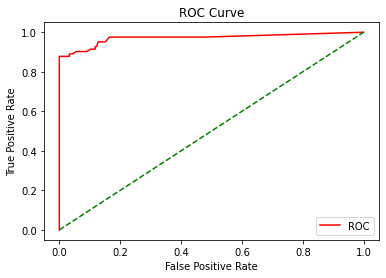

roc-auc score:  0.97


In [99]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
prob = rf.predict_proba(test_clf_X)[:,1]
fper, tper, thresholds = roc_curve(test_clf_y, prob)
plot_roc_curve(fper, tper)
print('roc-auc score: ', round(roc_auc_score(test_clf_y,prob),2))

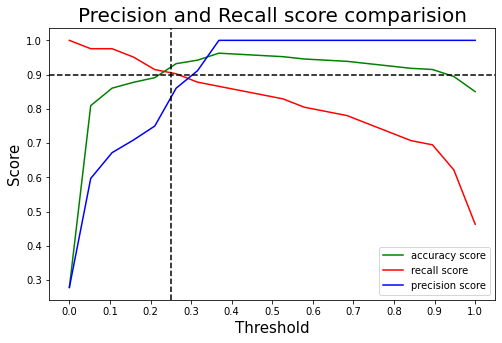

In [100]:
predicted_proba = rf.predict_proba(test_clf_X)

threshold_arr = np.linspace(0, 1, 20)
acc_arr = []
rec_arr = []
pre_arr = []
for th in threshold_arr:
    predicted = (predicted_proba[:,1] >= th).astype('int')
    
    acc_arr.append(accuracy_score(test_clf_y, predicted))
    rec_arr.append(recall_score(test_clf_y, predicted))
    pre_arr.append(precision_score(test_clf_y, predicted))
    
fig = plt.figure(figsize=(8,5))
plt.plot(threshold_arr, acc_arr, 'g', label='accuracy score')
plt.plot(threshold_arr, rec_arr, 'r', label='recall score')
plt.plot(threshold_arr, pre_arr, 'b', label='precision score')
plt.axhline(y=0.9, color='k', linestyle='--')
plt.axvline(x=0.25, color='k', linestyle='--')
plt.title("Precision and Recall score comparision", fontsize=20)
plt.xlabel("Threshold", fontsize=15)
plt.xticks(np.arange(0,1.1,.1))
plt.ylabel("Score", fontsize=15)
plt.legend()
plt.show()

accuracy_score: 0.939, recall score: 0.841, f1 score: 0.932


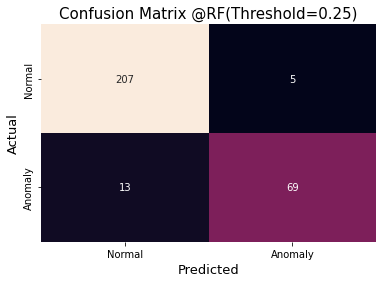

In [85]:
threshold = 0.25
predicted_proba = rf.predict_proba(test_clf_X)
predicted = (predicted_proba[:,1] >= threshold).astype('int')

acc = accuracy_score(test_clf_y, predicted)
rec = recall_score(test_clf_y, predicted)
pre = precision_score(test_clf_y, predicted) 

print("accuracy_score: {:.3f}, recall score: {:.3f}, f1 score: {:.3f}".format(acc, rec, pre))

plot_heatmap(test_clf_y, predicted, "Confusion Matrix @RF(Threshold=0.25)")


In [67]:
saved_model = joblib.dump(rf, './basic_rf.pkl')

## 예측값으로부터 이상원인 파악

In [170]:
temp = pd.DataFrame(pred, index=test_clf_X.index)
idx = temp[temp[0] == 1].index
anomaly_df = temp_df.iloc[idx,:].drop(columns=["index","MAP","Distance","Degree","Amplitude"]).sort_values("Timestamp")
anomaly_df

,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID,Case
30,AS10003SA,AS10003-04,2023-01-01 10:35:34,A3D02,Metrology-Type-01,AS1,2
47,AS10003SA,AS10003-12,2023-01-01 14:07:57,A3D02,Metrology-Type-01,AS1,2
50,AS10003SA,AS10003-13,2023-01-01 14:40:04,A3D02,Metrology-Type-01,AS1,2
52,AS10003SA,AS10003-14,2023-01-01 15:09:43,A3D02,Metrology-Type-01,AS1,2
126,AS10003SC,AS10003-23,2023-01-02 06:17:36,A3D01,Metrology-Type-01,AS1,10
...,...,...,...,...,...,...,...
964,AC10358SP,AC10358-04,2023-01-09 13:21:42,A3D01,Metrology-Type-01,AC1,9
969,AC10358SP,AC10358-07,2023-01-09 14:17:46,A3D01,Metrology-Type-01,AC1,9
970,AC10358SP,AC10358-08,2023-01-09 14:41:09,A3D01,Metrology-Type-01,AC1,9
980,AC10358SP,AC10358-13,2023-01-09 16:49:50,A3D01,Metrology-Type-01,AC1,9


In [190]:
anomaly_df["YMD"] = anomaly_df.Timestamp.apply(lambda x: datetime.strftime(x, "%Y-%m-%d"))
anomaly_df.YMD.unique()
for ymd in anomaly_df.YMD.unique():
    temp = anomaly_df[anomaly_df.YMD == ymd]
    print(f'============= {ymd} =============')
    print(f'검사장비 {temp.MachineID.unique()}')
    print(f'검사방법 {temp.StepID.unique()}')
    print(f'제품공정 {temp.DeviceID.unique()}')
    print("에 대한 확인이 필요합니다.\n")

============= 2023-01-01 =============
검사장비 ['A3D02']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-02 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-03 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01' 'Metrology-Type-02']
제품공정 ['AS1' 'AC1']
에 대한 확인이 필요합니다.

============= 2023-01-04 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-02']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-05 =============
검사장비 ['A3D01' 'A3D02']
검사방법 ['Metrology-Type-02' 'Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-06 =============
검사장비 ['A3D02']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-07 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-09 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1' 'AC1']
에 대한 확인이 필요합니다.



## 푸리에 변환의 이해를 위한 예시 시각화

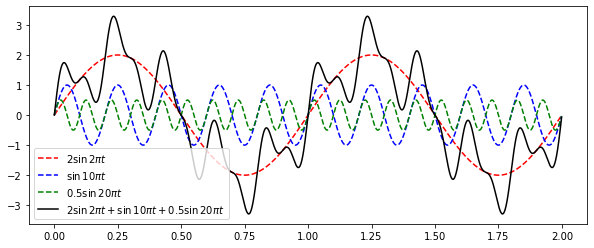

In [3]:
# 푸리에 적분 예시
fig = plt.figure(figsize=(10,4))
x = np.arange(0,2, 0.001)
y1 = 2*np.sin(2*np.pi*x)
y2 = np.sin(2*np.pi*5*x)
y3 = 0.5*np.sin(2*np.pi*10*x)
ySum = y1+y2+y3
plt.plot(x, y1, color='r', linestyle='--', label=r"${2}\sin {2\pi} t$")
plt.plot(x, y2, color='b', linestyle='--', label=r"$\sin {10\pi} t$")
plt.plot(x, y3, color='g', linestyle='--', label=r"${0.5}\sin {20\pi} t$")
plt.plot(x,ySum, color='k', label=r"${2}\sin{2\pi}t + \sin{10\pi}t + {0.5}\sin{20\pi}t$")
plt.legend()
plt.show()

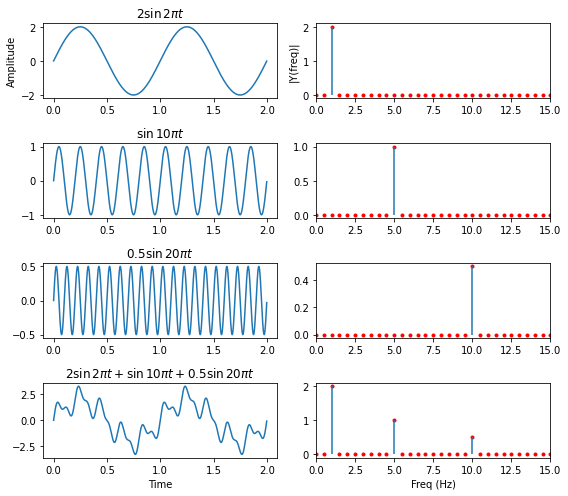

In [4]:
def fft_func(y):
    n = len(ySum)
    k = np.arange(n)
    Fs = 1/0.001
    T = n/Fs
    freq = k/T 
    freq = freq[range(int(n/2))]
    Y = 2* np.fft.fft(y)/n 
    amp = Y[range(int(n/2))]
    return freq, abs(amp)

def plot_fft(row, col, y):
    ax[row][col].plot(fft_func(y)[0], fft_func(y)[1], 'r', linestyle=' ', marker='.') 
    ax[row][col].vlines(fft_func(y)[0], [0], fft_func(y)[1])
    ax[row][col].set_xlim([0, 15])

fig, ax = plt.subplots(4, 2, figsize=(8,7))
ax[0][0].plot(x, y1)
ax[1][0].plot(x, y2)
ax[2][0].plot(x, y3)
ax[3][0].plot(x, ySum)
plot_fft(0,1,y1)
plot_fft(1,1,y2)
plot_fft(2,1,y3)
plot_fft(3,1,ySum)
ax[3][0].set_xlabel('Time')
ax[0][0].set_ylabel('Amplitude')
ax[0][1].set_ylabel('|Y(freq)|')
ax[3][1].set_xlabel('Freq (Hz)')

ax[0][0].set_title(r"${2}\sin {2\pi} t$")
ax[1][0].set_title(r"$\sin {10\pi} t$")
ax[2][0].set_title(r"${0.5}\sin {20\pi} t$")
ax[3][0].set_title(r"${2}\sin{2\pi}t + \sin{10\pi}t + {0.5}\sin{20\pi}t$")
plt.tight_layout()
plt.show()

In [12]:
x = np.arange(-1, 1, 0.01)
y = np.cos(2*np.pi*x)
if -0.5 <= x <= 0.5:
    y1 = np.cos(2*np.pi*x)
else:
    y1
fig = plt.figure(figsize=(10,4))
plt.plot(x,y)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()